In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
1407877 (Mon Feb 4 12:56:29 2019 +0000) [with local modifications]
This notebook was executed on: 
2021-05-19 12:11:50.662325


In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time
import gc
import glob
from matplotlib_venn import venn2
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, QTable, Table, join, vstack, hstack, setdiff, unique
import numpy as np
import pymoc 
from pymoc import MOC


from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

In [3]:
gc.collect()

22

In [4]:
def select_sample(catalogue, allbands, mocs_list, mcuts, ndet=2):
    """
    param.
    ---------------
    catalogue: astropy.table
        HELP catalogue 
    allbands: [[..., str]]
        Names of bands used in the selections: [[opt_bands], [nir_bands], [mir_bands]]
    mocs_list: : [..., str] 
        list containing the mocs fits files.
    mcuts: dict
        magnitude cuts limits for each band.
    ndet: int
        number of detections required per group of bands (opt/nir/mid). Default 2; it requires 2 detection on each to pass the selection.
    
    output
    ---------------
    nb_band: astropy.Table 
        Table with flags for each source indicating whether the source has at least "ndet" detections above the magnitude cut.
        Flags: optband=1, nirband=2, mirband=4, ndet_total = (optband + nirband + mirband)
    """
    import numpy as np
    from astropy.table import Column, Table, join
    import time
    from pymoc import MOC
    
    
    nb_band = {}
    nb_band['help_id'] = catalogue['help_id']
    nb = ['optband', 'nirband', 'mirband']
    nx = ['optvalue', 'nirvalue', 'mirvalue']
    
    r_filter = np.zeros(len(catalogue))

    # Name of all moc files 
    mocs = [x[12:] for x in mocs_list]
    path_mocs = mocs_list[0][:12]
                  

    for idx, bands in enumerate(allbands):
        nb_band[nb[idx]] = np.zeros(len(catalogue))
        nb_filter = np.zeros(len(catalogue))

        for i, filt in enumerate(bands):
            # mocs in that filter
            mocs_filt = [moc for moc in mocs if filt in moc]
            ind = np.zeros(len(catalogue))
            for moc_ in mocs_filt:
                # Get the name of the filter and survey
                m = moc_[:-18]
                
                # Read in the moc for the specific survey     
                moc = MOC()
                moc.read(path_mocs+moc_)
                ind_moc = inMoc(catalogue['ra'], catalogue['dec'],moc)
                
                # Source 'detection'
                ind_filter = 1 * (catalogue['m_'+filt] <= mcuts[m]) # Sources with magnitude below the magnitud cut defined for that survey
                ind_filter = ind_filter * ind_moc # Sources within the moc survey
                ind += ind_filter

            nb_filter += ind 
            # Count sources detected on the 'r' filter
            if '_r' in filt:
                r_filter += ind                   
                
        # sources detected in at least two filters of those bands (opt, nir, mir)
        if idx==2:
            n = 2
        else:
            n = 1
        # add flag: 1 * opt ; 2 * nir ; 4 * mir    
        nb_band[nb[idx]] += (idx+n) * (nb_filter >= ndet)  
    
    nb_band = Table(nb_band)
    
    # at least 1det in r band
    has_r_det = 1 * (r_filter >= 1)
    nb_band['optband'] = nb_band['optband'] * has_r_det
            
    total = np.zeros(len(catalogue))
    for i in range(len(allbands)):
        total += nb_band[nb[i]]

    nb_band['ndet_total'] = total
    
    return nb_band


In [5]:
def select_sample_subfiles(file_list, allbands, mocs_list, mcut, ndet=2):
    
    nb = ['optband', 'nirband', 'mirband']
    names_det = ['help_id'] + nb[:len(allbands)] + ['ndet_total']
    nb_band = Table(names=names_det, dtype=('str','float','float','float'))  
    
    # read sub_files to calculate snr per each band
    ################################################
    print('Reading sub_catalogues')
    start = time.time()  
    for idx, sub_file in enumerate(file_list):
        print('subfile: ', idx)
        start_sub = time.time() 
        
        sub_catalogue = Table.read(sub_file)
        sub_nb_band = select_sample(sub_catalogue, allbands, mocs_list, mcut, ndet=ndet)
        nb_band = vstack([nb_band, sub_nb_band])
        
        end_sub = time.time()
        time_ = end_sub - start_sub
        print('select_sample subcatalogue time: ', time_)
        
        del sub_catalogue
        del sub_nb_band
        gc.collect()
    
    end = time.time()
    time_all = end - start
    print('select_sample total time: ', time_all)    
    
    return nb_band     

In [6]:
def compare_cats_venndiagram(cat1, cat2, ind_catalogue, ind_names, cat1name, cat2name, save=False):
    """
    """
    for i, ind_cat in enumerate(ind_catalogue):
#             print('joining catalogues')
        plt.figure(figsize=(10,10))
        set1 = set(cat1.tolist())
        set2 = set(cat2[ind_cat].tolist())

        out = venn2([set1, set2], (cat1name, cat2name))

        for text in out.set_labels:
            text.set_fontsize(20)
        plt.title(ind_names[i])
        
        if save==True:
            plt.savefig('./data/figs/'+ind_names[i]+'.png', format='png')
            plt.savefig('./data/figs/'+ind_names[i]+'.pdf', format='pdf')
        plt.show()


In [7]:
DMU_DIR = '../dmu_products/'
FIELD = 'Herschel-Stripe-82'

## 1. SELECTION FUNCTION

### 1.1 Read in files

#### MOCs

In [8]:
moc_list = glob.glob('./data/mocs/*.fits')
len(moc_list)

28

#### Masterlist / Subfiles

In [9]:
use_subfiles = True

if use_subfiles == False:
    print('masterlist')
#     masterfile = DMU_DIR + 'dmu1/dmu1_ml_Herschel-Stripe-82/data/master_catalogue_herschel-stripe-82_20180307.fits' # too big
#     masterlist = Table.read(masterfile, memmap=True)

else:
    file_list = glob.glob(DMU_DIR + 'dmu1/dmu1_ml_Herschel-Stripe-82/data/tiles/sub_catalogue_herschel-stripe-82_2021*.fits')
    print('There are {} subfiles'.format(len(file_list)))

There are 502 subfiles


### 1.2 Bands definition

In [10]:
# HELP bands
############

u = [                        'sdss_u']
g = ['suprime_g', 'decam_g', 'sdss_g']
r = ['suprime_r', 'decam_r', 'sdss_r']
i = ['suprime_i', 'decam_i', 'sdss_i']
z = ['suprime_z', 'decam_z', 'sdss_z']
y = ['suprime_y', 'decam_y']

y_nir = ['vista_y',  'ukidss_y']
h = ['vista_h',  'ukidss_h']
j = ['vista_j',  'ukidss_j']
k = ['vista_ks', 'ukidss_k']

helpbands = [u + g + r + i + z + y] + [y_nir + h + j + k] 

### 1.3 Magnitude cuts

In [11]:
# SDSS
magcuts_sdss = {'sdss_u': 22.8,
 'sdss_g': 23.7,
 'sdss_r': 23.5,
 'sdss_i': 22.9,
 'sdss_z': 21.5}

# HSC
magcuts_hsc = {
    'suprime_g': 25.4,
    'suprime_r': 25.4, 
    'suprime_i': 25.1,
    'suprime_z': 24.2,
    'suprime_y': 23.7}

# DECam: DECaLS + DES
magcuts_des = {'decam_g_des': 23.3,
 'decam_r_des': 23.1,
 'decam_i_des': 22.7,
 'decam_z_des': 21.8,
 'decam_y_des': 20.6}

magcuts_decals =  {'decam_g_decals': 23.9, 'decam_r_decals': 23.5, 'decam_z_decals': 22.5}

# VISTA: VHS + VICS82
magcuts_vhs = {'vista_y_vhs': 20.1,
 'vista_h_vhs': 19.6,
 'vista_j_vhs': 19.9,
 'vista_ks_vhs': 19.6}

magcuts_vics = {'vista_j_vics': 21.0,
 'vista_ks_vics': 21.0}

# UKIDSS - LAS
magcuts_ukidss = {'ukidss_h':19.0, 'ukidss_j':19.0, 'ukidss_k':19.0, 'ukidss_y':20.2}

In [12]:
mcuts = magcuts_sdss.copy()

mcuts.update(magcuts_hsc)
mcuts.update(magcuts_des)
mcuts.update(magcuts_decals)
mcuts.update(magcuts_vhs)
mcuts.update(magcuts_vics)
mcuts.update(magcuts_ukidss)
mcuts

{'sdss_u': 22.8,
 'sdss_g': 23.7,
 'sdss_r': 23.5,
 'sdss_i': 22.9,
 'sdss_z': 21.5,
 'suprime_g': 25.4,
 'suprime_r': 25.4,
 'suprime_i': 25.1,
 'suprime_z': 24.2,
 'suprime_y': 23.7,
 'decam_g_des': 23.3,
 'decam_r_des': 23.1,
 'decam_i_des': 22.7,
 'decam_z_des': 21.8,
 'decam_y_des': 20.6,
 'decam_g_decals': 23.9,
 'decam_r_decals': 23.5,
 'decam_z_decals': 22.5,
 'vista_y_vhs': 20.1,
 'vista_h_vhs': 19.6,
 'vista_j_vhs': 19.9,
 'vista_ks_vhs': 19.6,
 'vista_j_vics': 21.0,
 'vista_ks_vics': 21.0,
 'ukidss_h': 19.0,
 'ukidss_j': 19.0,
 'ukidss_k': 19.0,
 'ukidss_y': 20.2}

### 1.4 Flagged catalogue

In [ ]:
if use_subfiles == False:
    ind_cat = select_sample(masterlist, helpbands, moc_list, mcuts)

else:
    ind_cat = select_sample_subfiles(file_list, helpbands, moc_list, mcuts)


In [25]:
ind_cat = select_sample_subfiles(file_list[400:], helpbands, moc_list, mcuts)


Reading sub_catalogues
subfile:  0
select_sample subcatalogue time:  13.285945415496826
subfile:  1
select_sample subcatalogue time:  13.513476371765137
subfile:  2
select_sample subcatalogue time:  13.225817203521729
subfile:  3
select_sample subcatalogue time:  13.725852727890015
subfile:  4
select_sample subcatalogue time:  14.094137907028198
subfile:  5
select_sample subcatalogue time:  15.683226108551025
subfile:  6
select_sample subcatalogue time:  14.588437557220459
subfile:  7
select_sample subcatalogue time:  14.251049518585205
subfile:  8
select_sample subcatalogue time:  14.909456491470337
subfile:  9
select_sample subcatalogue time:  14.760400772094727
subfile:  10
select_sample subcatalogue time:  13.726845741271973
subfile:  11
select_sample subcatalogue time:  14.593874454498291
subfile:  12
select_sample subcatalogue time:  14.283641815185547
subfile:  13
select_sample subcatalogue time:  13.73071026802063
subfile:  14
select_sample subcatalogue time:  13.75347900390625

In [26]:
ind_cat.write('./data/ind_cat_sf_20210519_sub400_501.fits')

In [27]:
del ind_cat

## II Compare with Ldust catalogue

In [28]:
ind_catalogue = Table.read('./data/ind_cat_sf_20210519_all.fits')

In [29]:
ldustfile = DMU_DIR + 'dmu28/dmu28_Herschel-Stripe-82/data/Ldust/old/herschel_stripe_82_Ldust_prediction_all.fits'
ldust_cat = Table.read(ldustfile, memmap=True)
ldust_cat['id'].name = 'help_id'

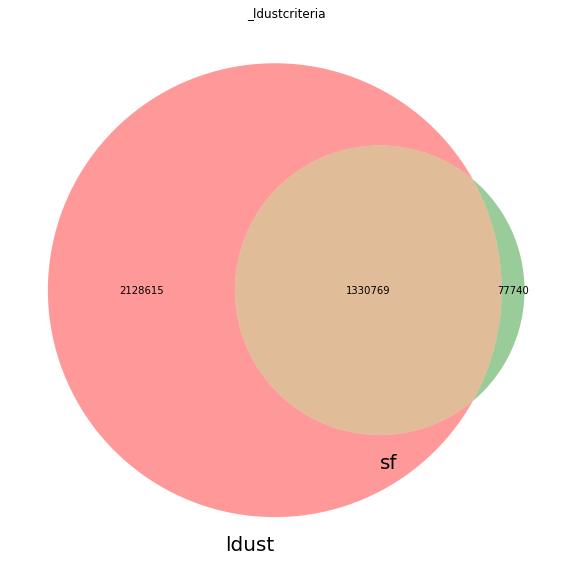

In [31]:
# indexs catalogues based on flags
ind_catalogue_ldustcriteria = (ind_catalogue['ndet_total']==3) | (ind_catalogue['ndet_total']==7)
# ind_catalogue_iraccriteria = ind_catalogue['ndet_total']>=5


# Compare sources after selection criteria with ldust catalogue 
# Plotting Venn diagrams 
#########################################
ind_catalogues = np.array([
    ind_catalogue_ldustcriteria,
#     ind_catalogue_iraccriteria
    ])

ind_names =  np.array([
    '_ldustcriteria',
#     cat_name+'_iraccriteria'
])

# Venn Diagrams
compare_cats_venndiagram(ldust_cat['help_id'], ind_catalogue['help_id'], ind_catalogues, ind_names, 'ldust', 'sf', save=True)


## III Selected catalogue

### 3.1 Define the final sample


In [ ]:
hs82_cat_selected = masterlist[ind_catalogue_ldustcriteria]

In [ ]:
# len(hs82_cat_selected)

In [ ]:
hs82_cat_selected.write('./data/hs82_selected_sources_sf_20210506.fits')